# Train Hate Speech Classification Neural Network Models

With the data cleaned and processed, this notebook implements model training on the data sets. The code in this notebook assumes that cleaned data is in the filepath `"data/combined_deduped.csv"`.

In [1]:
import pandas as pd
import numpy as np
import spacy
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_fscore_support, classification_report
import matplotlib.pyplot as plt
import wandb
from tensorflow import keras
from wandb.keras import WandbCallback
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.sequence import pad_sequences

import en_core_web_md
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, Concatenate, GlobalMaxPooling1D

# Neural Network Baselines

## MLP

The "baseline" implementation of a neural network is more debatable. Our choice was to set up a simple multilayer perceptron with enough neurons and layers to be functional and little customization beyond that. 

First, we instantiate a CountVectorizer to transform the words into integer counts of word appearance. Next, we scale that data and convert it from sparse matrices to arrays. Finally, we create, compile, and fit our model.

In [21]:
vect = CountVectorizer(stop_words = 'english', max_features=3000)
x_train_vect = vect.fit_transform(x_train)
x_val_vect = vect.transform(x_val)

In [22]:
scaler = StandardScaler(with_mean = False)
x_train_vect_scale = scaler.fit_transform(x_train_vect)
x_val_vect_scale = scaler.transform(x_val_vect)

In [23]:
x_train_vect_scale = x_train_vect_scale.toarray()
x_val_vect_scale = x_val_vect_scale.toarray()

In [24]:
model = Sequential([
    Dense(128, input_dim=3000, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
              ])

In [25]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [41]:
wandb.init(project="allay-ds-23")

results = model.fit(x_train_vect_scale,
                    y_train,
                    epochs=5,
                   batch_size=20)

Train on 99459 samples
Epoch 1/5
99459/99459 [==============================] - 37s 376us/sample - loss: 0.6787 - accuracy: 0.8567
Epoch 2/5
99459/99459 [==============================] - 24s 239us/sample - loss: 0.2212 - accuracy: 0.9178
Epoch 3/5
99459/99459 [==============================] - 23s 231us/sample - loss: 0.1629 - accuracy: 0.9403
Epoch 4/5
99459/99459 [==============================] - 23s 227us/sample - loss: 0.1284 - accuracy: 0.9523
Epoch 5/5
99459/99459 [==============================] - 22s 216us/sample - loss: 0.1105 - accuracy: 0.9586


In [42]:
score = model.evaluate(x_val_vect_scale, y_val)
y_pred = model.predict(x_val_vect_scale, batch_size=64, verbose=1)
y_pred = np.round(y_pred)

17552/17552 [==============================] - 3s 188us/sample


In [43]:
print(classification_report(y_val, y_pred, digits=4))

              precision    recall  f1-score   support

       False     0.8485    0.8924    0.8699     10223
        True     0.8382    0.7777    0.8069      7329

    accuracy                         0.8445     17552
   macro avg     0.8434    0.8351    0.8384     17552
weighted avg     0.8442    0.8445    0.8436     17552



In [44]:
accuracy, precision, recall, f1 = .8445, .8382, .7777, .8069

wandb.log({'accuracy':accuracy, 'recall':recall, 
               'f1':f1, 'precision':precision})

Next we try the same thing, but with a Tf-Idf vectorizer.

In [45]:
vect = TfidfVectorizer(stop_words = 'english', max_features=3000)
x_train_vect = vect.fit_transform(x_train)
x_val_vect = vect.transform(x_val)

In [46]:
x_train_vect = x_train_vect.toarray()
x_val_vect = x_val_vect.toarray()

In [47]:
model = Sequential([
    Dense(128, input_dim=3000, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
              ])

In [48]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [49]:
wandb.init(project="allay-ds-23")
results = model.fit(x_train_vect,
                    y_train,
                    epochs=5,
                   batch_size=20)

Train on 99459 samples
Epoch 1/5
99459/99459 [==============================] - 25s 253us/sample - loss: 0.3500 - accuracy: 0.8495
Epoch 2/5
99459/99459 [==============================] - 31s 307us/sample - loss: 0.3024 - accuracy: 0.8731
Epoch 3/5
99459/99459 [==============================] - 20s 206us/sample - loss: 0.2700 - accuracy: 0.8885
Epoch 4/5
99459/99459 [==============================] - 20s 204us/sample - loss: 0.2257 - accuracy: 0.9090
Epoch 5/5
99459/99459 [==============================] - 20s 203us/sample - loss: 0.1735 - accuracy: 0.9319


In [51]:
y_pred = model.predict(x_val_vect, batch_size=64, verbose=1)
y_pred = np.round(y_pred)
print(classification_report(y_val, y_pred, digits=4))

17552/17552 [==============================] - 1s 54us/sample
              precision    recall  f1-score   support

       False     0.8541    0.9035    0.8781     10223
        True     0.8535    0.7847    0.8177      7329

    accuracy                         0.8539     17552
   macro avg     0.8538    0.8441    0.8479     17552
weighted avg     0.8538    0.8539    0.8528     17552



In [53]:
accuracy, precision, recall, f1 = .8539, .8535, .7847, .8177

wandb.log({'accuracy':accuracy, 'recall':recall, 
               'f1':f1, 'precision':precision})

## RNN + LSTM

The next model we try is a recurrent neural network with LSTM. This relies on having pickled lemmatized data in the filepath `data/lemmas_2020-05-04-16-27-18Z.pkl.xz`. See other notebook for lemmatization methods.

In [60]:
lemmas = pd.read_pickle("data/lemmas_2020-05-04-16-27-18Z.pkl.xz", compression = 'xz')

In [61]:
lemmas.head()

sm_lemmas  \
0  [beat, Dr., Dre, urbeat, Wired, Ear, Headphone...   
1  [@Papapishu, man, fucking, rule, party, perpet...   
2  [time, draw, close, 128591;&#127995, Father, d...   
3  [notice, start, act, different, distant, peep,...   
4  [forget, unfollower, believe, grow, new, follo...   

                                           md_lemmas  \
0  [beat, Dr., Dre, urbeat, Wired, ear, Headphone...   
1  [@Papapishu, man, fucking, rule, party, perpet...   
2  [time, draw, close, 128591;&#127995, Father, d...   
3  [notice, start, act, different, distant, peep,...   
4  [forget, unfollower, believe, grow, new, follo...   

                                           lg_lemmas  inappropriate  
0  [beat, Dr., Dre, urBeats, wire, Ear, Headphone...           True  
1  [@Papapishu, man, fucking, rule, party, perpet...           True  
2  [time, draw, close, 128591;&#127995, Father, d...          False  
3  [notice, start, act, different, distant, peep,...          False  
4  [forget, unfollower, believe, grow, new, follo...          False

In [63]:
medium_lemmas = lemmas[["md_lemmas", "inappropriate"]].copy()
del lemmas

In [82]:
train, test = train_test_split(medium_lemmas, test_size=.2, random_state=42)
train, val = train_test_split(train, test_size=.15, random_state=42)
target = 'inappropriate'

In [83]:
y_train = train[target]
y_val = val[target]

x_train = train.drop([target], axis=1)
x_val = val.drop([target], axis=1)

We look to get each lemma in our file (up to a maximum number of features) coded to an integer so we can pass these tweets into an embedding layer. Since preprocessing was done in the lemmatization step, we create a CountVectorizer -- whose attributes we will access to create our vocab -- but turn off all of its automatic text processing.

In [102]:
def do_nothing(tokens):
    return tokens

In [125]:
vectorizer = CountVectorizer(tokenizer=do_nothing, preprocessor=None, lowercase=False, stop_words="english", max_features=5000, min_df=.0001)

In [126]:
vectorizer.fit(x_train["md_lemmas"])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=False, max_df=1.0, max_features=5000, min_df=0.0001,
                ngram_range=(1, 1), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function do_nothing at 0x0000028736EF8948>,
                vocabulary=None)

In [127]:
word2idx = {word: idx for idx, word in enumerate(vectorizer.get_feature_names())}

In [ ]:
word2idx[:3]

In [111]:
def to_sequence(index, text):
    indexes = [index[word] for word in text if word in index]
    return indexes

In [129]:
x_train["integers"] = x_train["md_lemmas"].apply(lambda x: to_sequence(word2idx, x))
x_val["integers"] = x_val["md_lemmas"].apply(lambda x: to_sequence(word2idx, x))

In [130]:
x_train.head()

md_lemmas  \
14520   [.@pepsi, think, protest, hip, cute, thing, mi...   
68713   [Mississauga, load, line, finally, click, Spen...   
117901  [kejriwal, accept, role, making, udtapunjab, c...   
61528   [@AsEasyAsRiding, @lastnotlost, @shoestringcyc...   
115752  [time, like, boxer, rapper, etc, bitch, fuckin...   

                                                 integers  
14520    [4580, 3824, 2838, 2077, 4579, 3360, 3843, 2931]  
68713          [3221, 3199, 2539, 1851, 3212, 4612, 1531]  
117901               [1258, 4043, 3283, 4721, 1955, 3838]  
61528                                              [3193]  
115752  [4608, 3193, 3888, 1578, 2632, 2805, 1781, 355...

As reviews are likely to be longer than tweets, we increase our max sequence length to allow our model to process texts of longer length. 

In [145]:
max_seq_length = (max(x_train["integers"].apply(lambda x: len(x))) * 2)
max_seq_length

60

In [116]:
len(word2idx)

5000

In [136]:
n_features = len(vectorizer.get_feature_names())
x_train_sequences = pad_sequences(x_train["integers"], maxlen = max_seq_length, value=n_features)

In [141]:
x_val_sequences = pad_sequences(x_val["integers"], maxlen=max_seq_length, value=n_features)

In [138]:
x_train_sequences[0]

array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000,
       5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000,
       4580, 3824, 2838, 2077, 4579, 3360, 3843, 2931])

In [139]:
model = Sequential()
model.add(Embedding(len(vectorizer.get_feature_names()) + 1,
                    64,
                    input_length=max_seq_length))
model.add(LSTM(64))
model.add(Dense(units=1, activation='sigmoid'))
 
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 30, 64)            320064    
_________________________________________________________________
lstm_9 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 353,153
Trainable params: 353,153
Non-trainable params: 0
_________________________________________________________________
None


In [142]:
WANDB_NOTEBOOK_NAME = "train_nn_models.ipynb"
wandb.init(project="allay-ds-23", config = {"epochs": 3, "optimizer": "adam", "batch_size": 20})
results = model.fit(x_train_sequences,
                    y_train,
                    epochs=3,
                   batch_size=20,
                   callbacks=[WandbCallback(validation_data=(x_val_sequences, y_val),
                labels=["appropriate", "inappropriate"])])

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.8.35 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 99459 samples
Epoch 1/3
99459/99459 [==============================] - 75s 759us/sample - loss: 0.3463 - accuracy: 0.8545
Epoch 2/3
99459/99459 [==============================] - 69s 697us/sample - loss: 0.3067 - accuracy: 0.8713
Epoch 3/3
99459/99459 [==============================] - 60s 604us/sample - loss: 0.2832 - accuracy: 0.8793


Run pip install nbformat to save notebook history


In [144]:
y_pred = model.predict(x_val_sequences, batch_size=64, verbose=1)
y_pred = np.round(y_pred)
print(classification_report(y_val, y_pred, digits=4))

17552/17552 [==============================] - 1s 59us/sample
              precision    recall  f1-score   support

       False     0.8569    0.9119    0.8835     10223
        True     0.8650    0.7876    0.8245      7329

    accuracy                         0.8600     17552
   macro avg     0.8609    0.8497    0.8540     17552
weighted avg     0.8603    0.8600    0.8589     17552



## CNN

The next model we try is a convolutional neural network as described in [arXiv:1510.03820 [cs.CL]](https://arxiv.org/abs/1510.03820).

Implementation details were derived from:
- 'Transfer learning with spaCy embeddings' section of [Getting started with Keras for NLP](https://remove-js.com/https://nlpforhackers.io/keras-intro/)
- [Introduction to 1D Convolutional Neural Networks for NLP](https://github.com/Tixierae/deep_learning_NLP/blob/master/CNN_IMDB/cnn_imdb.ipynb)

This relies on having pickled lemmatized data in the filepath `data/lemmas_2020-05-04-16-27-18Z.pkl.xz`. See other notebook for lemmatization methods.

In [2]:
lemmas = pd.read_pickle("data/lemmas_2020-05-04-16-27-18Z.pkl.xz", compression = 'xz')

In [3]:
lemmas.head()

sm_lemmas  \
0  [beat, Dr., Dre, urbeat, Wired, Ear, Headphone...   
1  [@Papapishu, man, fucking, rule, party, perpet...   
2  [time, draw, close, 128591;&#127995, Father, d...   
3  [notice, start, act, different, distant, peep,...   
4  [forget, unfollower, believe, grow, new, follo...   

                                           md_lemmas  \
0  [beat, Dr., Dre, urbeat, Wired, ear, Headphone...   
1  [@Papapishu, man, fucking, rule, party, perpet...   
2  [time, draw, close, 128591;&#127995, Father, d...   
3  [notice, start, act, different, distant, peep,...   
4  [forget, unfollower, believe, grow, new, follo...   

                                           lg_lemmas  inappropriate  
0  [beat, Dr., Dre, urBeats, wire, Ear, Headphone...           True  
1  [@Papapishu, man, fucking, rule, party, perpet...           True  
2  [time, draw, close, 128591;&#127995, Father, d...          False  
3  [notice, start, act, different, distant, peep,...          False  
4  [forget, unfollower, believe, grow, new, follo...          False

In [4]:
# Using lemmas created with spaCy's 'en_core_web_md' pre-trained model.
medium_lemmas = lemmas[["md_lemmas", "inappropriate"]].copy()
del lemmas

In [5]:
# Initialize NLP model and related constants
nlp_md = en_core_web_md.load()

EMBEDDINGS_LEN = len(nlp_md.vocab['apple'].vector)
print("EMBEDDINGS_LEN =", EMBEDDINGS_LEN)

EMBEDDINGS_LEN = 300


We look to get each lemma in our file (up to a maximum number of features) coded to an integer so we can pass these tweets into an embedding layer. Since preprocessing was done in the lemmatization step, we create a CountVectorizer -- whose attributes we will access to create our vocab -- but turn off all of its automatic text processing.

In [6]:
def do_nothing(tokens):
    """Returns the variable passed as an argument.

    This function is a NO-OP to allow initializing a CountVectorizer with pre-tokenized data.

    :param tokens: collection of tokens
    :returns: unaltered collection of tokens
    """
    return tokens

In [7]:
# Instantiate and fit vectorizer instance and define related constants

vectorizer = CountVectorizer(tokenizer=do_nothing, preprocessor=None, lowercase=False, stop_words="english", max_features=5000, min_df=.0001).fit(medium_lemmas['md_lemmas'])

N_FEATURES = len(vectorizer.get_feature_names())
print('N_FEATURES:', N_FEATURES)

N_FEATURES: 5000


In [8]:
# Create sequences of integer indexes into the vocabulary

word2idx = {word: idx for idx, word in enumerate(vectorizer.get_feature_names())}

def to_sequence(index, text):
    indexes = [index[word] for word in text if word in index]
    return indexes

medium_lemmas["md_sequences"] = medium_lemmas["md_lemmas"].apply(lambda x: to_sequence(word2idx, x))

In [9]:
# Define MAX_SEQ_LENGTH constant to be twice the max length in out training data set.en_core_web_md
# We expect the content in production to be longer than the content we are training on.

MAX_SEQ_LENGTH = (max(medium_lemmas['md_sequences'].apply(lambda x: len(x))) * 2)
print('MAX_SEQ_LENGTH:', MAX_SEQ_LENGTH)

MAX_SEQ_LENGTH: 60


In [10]:
# Reproducible train / val / test split
def tvt_split(df, target='inappropriate'):
    x_train, x_test, y_train, y_test = train_test_split(df.drop(columns=target), df[target], test_size=0.2, random_state=42)
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.15, random_state=42)
    return x_train, y_train, x_val, y_val # , x_test, y_test

In [11]:
train, y_train, val, y_val = tvt_split(medium_lemmas)
print('Train:', train.shape, y_train.shape)
print('Val:', val.shape, y_val.shape)
train.head()

Train: (99459, 2) (99459,)
Val: (17552, 2) (17552,)


md_lemmas  \
14520   [.@pepsi, think, protest, hip, cute, thing, mi...   
68713   [Mississauga, load, line, finally, click, Spen...   
117901  [kejriwal, accept, role, making, udtapunjab, c...   
61528   [@AsEasyAsRiding, @lastnotlost, @shoestringcyc...   
115752  [time, like, boxer, rapper, etc, bitch, fuckin...   

                                             md_sequences  
14520    [4582, 3816, 2815, 2036, 4581, 3333, 3835, 2912]  
68713          [3192, 3171, 2507, 1815, 3183, 4614, 1491]  
117901               [1224, 4036, 3253, 4721, 1919, 3830]  
61528                                              [3165]  
115752  [4610, 3165, 3880, 1540, 2600, 2779, 1748, 352...

In [12]:
# Pad or trim sequences to MAX_SEQ_LENGTH

x_train = pad_sequences(train['md_sequences'], maxlen = MAX_SEQ_LENGTH, value=N_FEATURES)
x_val = pad_sequences(val['md_sequences'], maxlen = MAX_SEQ_LENGTH, value=N_FEATURES)
# x_test = pad_sequences(test['md_sequences'], maxlen = MAX_SEQ_LENGTH, value=N_FEATURES)

In [13]:
# Create embeddings index from spaCy's pretrained 'en_core_web_md' model

embeddings_index = np.zeros((N_FEATURES + 1, EMBEDDINGS_LEN))
for word, idx in word2idx.items():
  try:
    embedding = nlp_md.vocab[word].vector
    embeddings_index[idx] = embedding
  except:
    pass

In [16]:
# Export data for use in WandB hyperparameter sweeps

import pickle

cnn_data = {
    'EMBEDDINGS_LEN': EMBEDDINGS_LEN,
    'MAX_SEQ_LENGTH': MAX_SEQ_LENGTH,
    'N_FEATURES': N_FEATURES,
    'x_train': x_train,
    'x_val': x_val,
    'y_train': y_train,
    'y_val': y_val,
    'embeddings_index': embeddings_index
}

with open('data/cnn_data.pkl', 'wb') as f:
    pickle.dump(cnn_data, f)

In [35]:
# Build CNN model
# https://github.com/Tixierae/deep_learning_NLP/blob/master/CNN_IMDB/cnn_imdb.ipynb

# based on pdf
num_filters = 2
# based on above repo
dropout_rate = 0.3

# Input Layer
inputs = Input(shape=(MAX_SEQ_LENGTH,))

# Embedding layer
embedding_layer = Embedding(input_dim=N_FEATURES + 1,
                          output_dim=EMBEDDINGS_LEN,
                          weights=[embeddings_index], # we pass our pre-trained embeddings
                          input_length=MAX_SEQ_LENGTH,
                          trainable=False,
                          ) (inputs)

embedding_dropped = Dropout(dropout_rate)(embedding_layer)

# Convolution Layer - 3 Convolutions, each connected to the input embeddings
# Branch a
conv_a = Conv1D(filters = num_filters,
              kernel_size = 2,
              activation = 'relu',
              )(embedding_dropped)

pooled_conv_a = GlobalMaxPooling1D()(conv_a)

pooled_conv_dropped_a = Dropout(dropout_rate)(pooled_conv_a)

# Branch b
conv_b = Conv1D(filters = num_filters,
              kernel_size = 3,
              activation = 'relu',
              )(embedding_dropped)

pooled_conv_b = GlobalMaxPooling1D()(conv_b)

pooled_conv_dropped_b = Dropout(dropout_rate)(pooled_conv_b)

# Branch c
conv_c = Conv1D(filters = 2,
              kernel_size = 4,
              activation = 'relu',
              )(embedding_dropped)

pooled_conv_c = GlobalMaxPooling1D()(conv_c)

pooled_conv_dropped_c = Dropout(dropout_rate)(pooled_conv_c)

# Collect branches into a single Convolution layer
concat = Concatenate()([pooled_conv_dropped_a, pooled_conv_dropped_b, pooled_conv_dropped_c])

concat_dropped = Dropout(dropout_rate)(concat)

# Dense output layer
prob = Dense(units = 1, # dimensionality of the output space
             activation = 'sigmoid',
             )(concat_dropped)

model = Model(inputs, prob)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 60, 300)      1500300     input_3[0][0]                    
__________________________________________________________________________________________________
dropout_6 (Dropout)             (None, 60, 300)      0           embedding_2[0][0]                
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 59, 2)        1202        dropout_6[0][0]                  
______________________________________________________________________________________________

In [40]:
WANDB_NOTEBOOK_NAME = "train_nn_models.ipynb"
wandb.init(project="allay-ds-23", config = {"epochs": 3, "optimizer": "adam", "batch_size": 20})
results = model.fit(x_train,
                    y_train,
                    validation_data=(x_val, y_val),
                    epochs=3,
                    batch_size=20,
                    callbacks=[WandbCallback(validation_data=(x_val, y_val),
                    labels=["appropriate", "inappropriate"])])

wandb: Wandb version 0.8.35 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Train on 99459 samples, validate on 17552 samples
Epoch 1/3
99459/99459 [==============================] - 66s 666us/sample - loss: 0.4234 - accuracy: 0.8265 - val_loss: 0.3663 - val_accuracy: 0.8491
Epoch 2/3
99459/99459 [==============================] - 74s 741us/sample - loss: 0.4216 - accuracy: 0.8272 - val_loss: 0.3677 - val_accuracy: 0.8496
Epoch 3/3
99459/99459 [==============================] - 78s 783us/sample - loss: 0.4216 - accuracy: 0.8270 - val_loss: 0.3652 - val_accuracy: 0.8516


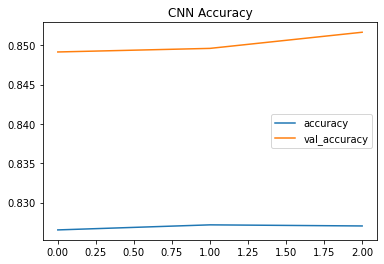

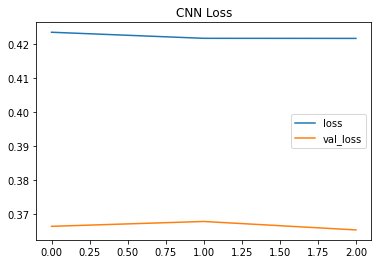

In [41]:
results_df = pd.DataFrame(results.history)
results_df[['accuracy', 'val_accuracy']].plot(title='CNN Accuracy');
results_df[['loss', 'val_loss']].plot(title='CNN Loss');

In [45]:
y_pred = model.predict(x_val, batch_size=64, verbose=1)
y_pred = np.round(y_pred)
print(classification_report(y_val, y_pred, digits=4))

17552/17552 [==============================] - 2s 131us/sample
              precision    recall  f1-score   support

       False     0.8145    0.9651    0.8834     10223
        True     0.9344    0.6934    0.7961      7329

    accuracy                         0.8516     17552
   macro avg     0.8744    0.8292    0.8397     17552
weighted avg     0.8645    0.8516    0.8469     17552

